<a href="https://colab.research.google.com/github/renyuanL/_JosephLin_2023/blob/main/ryMLP001_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

k= 0, l= 0
layer.weights= array([[ 0.31151847, -0.02391601,  0.02315599, -0.24947941,  0.10504302],
       [-0.19709519,  0.07728401, -0.33032188, -0.34053091, -0.08297026]]),
layer.bias= array([[-0.07318048, -0.23189074, -0.36840315, -0.46078946, -0.47476817]])

k= 1, l= 2
layer.weights= array([[-0.22844971],
       [-0.03814656],
       [ 0.22624328],
       [-0.0251283 ],
       [ 0.40405082]]),
layer.bias= array([[-0.4647802]])

i= 0, err= 1.0281224936592155
i= 1, err= 0.8095277743000775
i= 2, err= 0.46240363669496953
i= 3, err= 0.22964912856539904
i= 4, err= 0.1706334760933568
i= 5, err= 0.1456077227809668
i= 6, err= 0.13381698279493465
i= 7, err= 0.11229513165249684
i= 8, err= 0.11257081572723225
i= 9, err= 0.1097578114312328
i= 10, err= 0.10355579148063608
i= 11, err= 0.10311119944455772
i= 12, err= 0.09809813393218743
i= 13, err= 0.09632351813070272
i= 14, err= 0.08589994392717502
i= 15, err= 0.08961407215840451
i= 16, err= 0.08676162585237003
i= 17, err= 0.0889573146192444
i= 

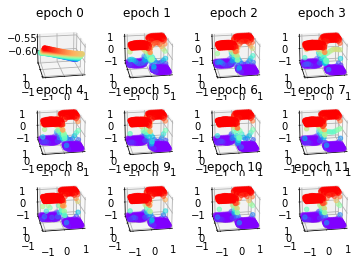

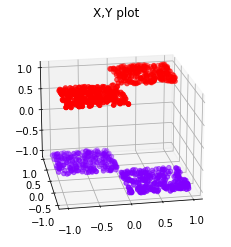

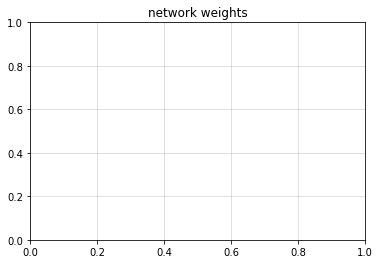

In [1]:
'''
Created on 2023-03-29
Author: Renyuan Lyu
Description: A simple MLP with 2 hidden layers
Task: xor problem
Path: Medium-Python-Neural-Network-master\ryMLP001.py
'''
#%%
import numpy as np

# activation function and its derivative
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1-np.tanh(x)**2

# loss function and its derivative (prime)
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size

# Base class
class Layer:
    def __init__(self):
        self.input=  None
        self.output= None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights= np.random.rand(
                        input_size, output_size
                        ) - 0.5
        self.bias=    np.random.rand(
                        1, output_size
                        ) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input=  input_data # a row vector
        self.output= self.input @ self.weights + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, 
                             learning_rate):
        
        input_error=   output_error @ self.weights.T # dE/dX = dE/dY @ dY/dX
        weights_error= self.input.T @ output_error   # dE/dW = dE/dY @ dY/dW

        # dBias= output_error

        # update parameters
        self.weights -= weights_error * learning_rate
        self.bias    -= output_error  * learning_rate

        return input_error

# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation=       activation
        self.activation_prime= activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input=  input_data
        self.output= self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, 
                             learning_rate):
        input_error= output_error * self.activation_prime(self.input) 
        # element-wise multiplication 
        
        return input_error

class Network:
    def __init__(self, layers= []):
        self.layers= layers
        self.loss=   None
        self.loss_prime= None

        self.fig= plt.figure()
        self.ax=  self.fig.add_subplot(1,1,1, title= 'network weights')

    # add layer to network
    def add(self, layers):
        self.layers += layers
        return self
    
    def __add__(self, layers):
        return self.add(layers)
    
    def __repr__(self):
        return str(self.layers)
    
    def showLayerParams(self):
        k= 0
        for (l, layer) in enumerate(self.layers):
            if isinstance(layer, FCLayer):
                print(f'{k= }, {l= }\n{layer.weights= },\n{layer.bias= }\n')
            
                # plot layer weights in line plot
                '''
                self.ax=  self.fig.add_subplot(1,2,k%(1*2)+1, 
                                               title= f'Layer {l= }')
                self.ax.plot(layer.weights)
                '''
                k += 1
                #plt.show()


    # set loss to use
    def setLoss(self, loss, loss_prime):
        self.loss= loss
        self.loss_prime= loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples= len(input_data)
        results= []

        # run network over all samples
        for i in range(samples):
            
            # forward propagation
            output= input_data[i]
            for layer in self.layers:
                output= layer.forward_propagation(
                    output
                    )

            results += [output]

        return results

    # train the network
    def _shuffle(self, x_train, y_train):
        # sample dimension first
        samples= len(x_train)
        indices= np.arange(samples)
        np.random.shuffle(indices)

        x_train= x_train[indices]
        y_train= y_train[indices]

        return x_train, y_train
    
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            
            x_train, y_train= self._shuffle(x_train, y_train)

            err = 0
            for j in range(samples):
                # forward propagation
                output= x_train[j]
                for layer in self.layers:
                    output= layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error= self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error= layer.backward_propagation(
                        error, learning_rate
                        )

            # calculate average error on all samples
            err /= samples

            print(f'{i= }, {err= }')

import matplotlib.pyplot as plt

# decision boundary plot
fig= plt.figure()
#ax=  fig.add_subplot(111, projection="3d")

subplots=0

def decision_boundary_plot(net, show= True):
    #global fig, ax
    #ax.clear()
    global subplots
    
    
    points= []
    for x in np.linspace(-1, 1, 20):
        for y in np.linspace(-1, 1, 20):
            z= net.predict([[x, y]])
            points += [(x, y, z[0][0,0])]

    points= np.array(points)

    #fig= plt.figure()
    

    ax= fig.add_subplot(
        3, 4, 
        subplots%(3*4)+1, 
        projection= "3d",
        title= f'epoch {subplots}'
        )
    subplots += 1

    ax.scatter(
        points[:, 0], 
        points[:, 1], 
        points[:, 2], 
        c= points[:, 2], 
        cmap= "rainbow")
    
    ax.view_init(azim= -100, elev= 20)

    if show==True:
        plt.show()
    

def XY_plot(X, Y, show= True):
    '''
    plot X,Y similar to that in decision_boundary_plot
    '''

    points= []
    for x,y in zip(X,Y):
        for i in range(len(x)):
            points += [(x[i][0], x[i][1], y[i][0])]

    points= np.array(points)

    fig= plt.figure()

    ax= fig.add_subplot(
        1, 1, 1, 
        projection= "3d",
        title= 'X,Y plot')
    
    ax.scatter(
        points[:, 0], 
        points[:, 1], 
        points[:, 2], 
        c= points[:, 2], 
        cmap= "rainbow")
    
    ax.view_init(azim= -100, elev= +20)

    if show==True:
        plt.show()





def main():

    # training data
    X= [[[-1, -1]], 
        [[-1, +1]], 
        [[+1, -1]], 
        [[+1, +1]]]
    
    Y= [[[+1]], 
        [[-1]], 
        [[-1]], 
        [[+1]]]
    
    X+=[[[-.1, -.1]], 
        [[-.1, +.1]], 
        [[+.1, -.1]], 
        [[+.1, +.1]]]
    
    Y+=[[[+1]], 
        [[-1]], 
        [[-1]], 
        [[+1]]]
    

    def generate_data(nsamples= 1_000, seed= 0):
        
        np.random.seed(seed)

        X= []
        Y= []
        for i in range(nsamples):
            x= np.random.rand(2) * 2 - 1
            y= np.sign(x[0] * x[1])
            y= np.array([y])
            X += [[x]]
            Y += [[y]]
        
        return X, Y
    
    X,Y= generate_data()

    

    X= np.array(X)
    Y= np.array(Y)

    XY_plot(X, Y, show= False)

    # mlp network

    mlp= Network([
        FCLayer(2,5),  ActivationLayer(tanh,tanh_prime),
        FCLayer(5,1),  ActivationLayer(tanh,tanh_prime)
    ])
    
    mlp.showLayerParams()
    decision_boundary_plot(mlp, show= False)
    
    


    # train (fit)
    mlp.setLoss(mse, mse_prime)
    for i in range(10):
        mlp.fit(
            X, Y, 
            epochs= 20, 
            learning_rate= 0.02)

        decision_boundary_plot(mlp, show= False)
        #mlp.showLayerParams()
    
    mlp.showLayerParams()
    decision_boundary_plot(mlp, show= True)
    

#%%

#from   mpl_toolkits.mplot3d import Axes3D

if __name__ == '__main__':
    main()